In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
def compute_sdr(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    # Compute gradients
    dz_dx, dz_dy = np.gradient(img.astype(float))
    # Surface area
    area = np.sum(np.sqrt(1 + dz_dx**2 + dz_dy**2))
    # Projected area
    proj_area = img.shape[0] * img.shape[1]
    # Sdr = (area - proj_area) / proj_area * 100
    sdr = (area - proj_area) / proj_area * 100
    return sdr

In [3]:
def compute_str(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        return None
    # Compute gradients
    dz_dx, dz_dy = np.gradient(img.astype(float))
    # Structure tensor components
    Jxx = np.sum(dz_dx**2)
    Jxy = np.sum(dz_dx * dz_dy)
    Jyy = np.sum(dz_dy**2)
    # Eigenvalues
    trace = Jxx + Jyy
    det = Jxx * Jyy - Jxy**2
    discriminant = trace**2 - 4 * det
    if discriminant < 0:
        return None  # Should not happen
    sqrt_disc = np.sqrt(discriminant)
    lambda1 = (trace + sqrt_disc) / 2
    lambda2 = (trace - sqrt_disc) / 2
    # Str = lambda2 / lambda1 (since lambda1 >= lambda2)
    if lambda1 == 0:
        return 0
    return lambda2 / lambda1

In [4]:
def compute_flow_direction(img):
    """
    Compute D8 flow direction for a height map.
    Returns a matrix where each cell contains the direction index (0-7) of steepest descent.
    Directions: 0=N, 1=NE, 2=E, 3=SE, 4=S, 5=SW, 6=W, 7=NW
    -1 if no downhill neighbor.
    """
    rows, cols = img.shape
    flow_dir = np.full((rows, cols), -1, dtype=int)
    directions = [(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]
    
    for i in range(rows):
        for j in range(cols):
            max_drop = 0
            best_dir = -1
            for d, (di, dj) in enumerate(directions):
                ni, nj = i + di, j + dj
                if 0 <= ni < rows and 0 <= nj < cols:
                    drop = img[i, j] - img[ni, nj]
                    if drop > max_drop:
                        max_drop = drop
                        best_dir = d
            flow_dir[i, j] = best_dir
    return flow_dir

In [5]:
def compute_flow_accumulation(flow_dir):
    """
    Compute flow accumulation from flow direction matrix.
    Returns accumulation matrix where each cell has the number of upstream cells draining to it.
    """
    rows, cols = flow_dir.shape
    accumulation = np.ones((rows, cols), dtype=int)
    directions = [(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]
    memo = {}
    
    def get_accum(i, j):
        if (i, j) in memo:
            return memo[(i, j)]
        acc = 1
        for d in range(8):
            di, dj = directions[d]
            ni, nj = i - di, j - dj  # cells that flow into this
            if 0 <= ni < rows and 0 <= nj < cols and flow_dir[ni, nj] == d:
                acc += get_accum(ni, nj)
        memo[(i, j)] = acc
        return acc
    
    for i in range(rows):
        for j in range(cols):
            accumulation[i, j] = get_accum(i, j)
    return accumulation

In [6]:
def identify_streams(accumulation, threshold=10):
    """
    Identify stream cells where accumulation > threshold.
    """
    return accumulation > threshold

def compute_drainage_density(streams, area):
    """
    Compute drainage density: total stream length / area.
    """
    stream_length = np.sum(streams)
    return stream_length / area

In [7]:
def compute_stream_orders(streams, flow_dir):
    """
    Compute Horton-Strahler stream orders for stream network.
    """
    rows, cols = streams.shape
    orders = np.zeros((rows, cols), dtype=int)
    directions = [(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]
    
    # Find sources
    sources = []
    for i in range(rows):
        for j in range(cols):
            if streams[i, j]:
                has_upstream = False
                for d in range(8):
                    di, dj = directions[d]
                    ni, nj = i - di, j - dj
                    if 0 <= ni < rows and 0 <= nj < cols and streams[ni, nj] and flow_dir[ni, nj] == d:
                        has_upstream = True
                        break
                if not has_upstream:
                    sources.append((i, j))
    
    from collections import deque
    queue = deque(sources)
    visited = set(sources)
    for s in sources:
        orders[s] = 1
    
    while queue:
        i, j = queue.popleft()
        if flow_dir[i, j] != -1:
            di, dj = directions[flow_dir[i, j]]
            ni, nj = i + di, j + dj
            if 0 <= ni < rows and 0 <= nj < cols and streams[ni, nj]:
                upstream_orders = []
                for d in range(8):
                    ui, uj = directions[d]
                    ui, uj = ni - ui, nj - uj
                    if 0 <= ui < rows and 0 <= uj < cols and streams[ui, uj] and flow_dir[ui, uj] == d:
                        if (ui, uj) not in visited:
                            break
                        upstream_orders.append(orders[ui, uj])
                else:
                    max_order = max(upstream_orders) if upstream_orders else 1
                    if len(upstream_orders) > 1 and len(set(upstream_orders)) == 1:
                        max_order += 1
                    if orders[ni, nj] == 0 or max_order > orders[ni, nj]:
                        orders[ni, nj] = max_order
                    if (ni, nj) not in visited:
                        visited.add((ni, nj))
                        queue.append((ni, nj))
    return orders

def compute_bifurcation_ratio(orders):
    """
    Compute average bifurcation ratio.
    """
    from collections import Counter
    order_counts = Counter(orders[orders > 0])
    ratios = []
    for n in sorted(order_counts.keys()):
        if n + 1 in order_counts:
            ratios.append(order_counts[n] / order_counts[n + 1])
    return np.mean(ratios) if ratios else 0

In [8]:
def compute_channel_tortuosity(streams, flow_dir, accumulation):
    """
    Compute tortuosity of the main channel: actual path length / straight-line distance.
    """
    rows, cols = streams.shape
    directions = [(-1, 0), (-1, 1), (0, 1), (1, 1), (1, 0), (1, -1), (0, -1), (-1, -1)]
    
    # Find outlet: cell with max accumulation
    outlet = np.unravel_index(np.argmax(accumulation), accumulation.shape)
    
    # Find longest path from outlet upstream
    def find_longest_path(start):
        max_length = 0
        max_path = []
        stack = [(start, [start])]
        visited = set()
        while stack:
            (i, j), path = stack.pop()
            if len(path) > max_length:
                max_length = len(path)
                max_path = path
            visited.add((i, j))
            for d in range(8):
                di, dj = directions[d]
                ni, nj = i - di, j - dj
                if 0 <= ni < rows and 0 <= nj < cols and streams[ni, nj] and flow_dir[ni, nj] == d and (ni, nj) not in visited:
                    stack.append(((ni, nj), path + [(ni, nj)]))
        return max_path
    
    main_path = find_longest_path(outlet)
    if len(main_path) < 2:
        return 0
    actual_length = len(main_path) - 1
    start = main_path[0]
    end = main_path[-1]
    straight = np.sqrt((start[0] - end[0])**2 + (start[1] - end[1])**2)
    return actual_length / straight if straight > 0 else 0

In [ ]:
data_dir = 'data/augmented_dataset'
classes = ['Channeling', 'Pillar', 'Roughness', 'Turbulence', 'Uniform']
sdr_data = []
for cls in classes:
    cls_dir = os.path.join(data_dir, cls)
    for img_file in os.listdir(cls_dir):
        if img_file.endswith('.jpg'):
            img_path = os.path.join(cls_dir, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            sdr = compute_sdr(img_path)
            str_val = compute_str(img_path)
            flow_dir = compute_flow_direction(img.astype(float))
            accumulation = compute_flow_accumulation(flow_dir)
            streams = identify_streams(accumulation, threshold=10)
            area = img.shape[0] * img.shape[1]
            drainage_density = compute_drainage_density(streams, area)
            orders = compute_stream_orders(streams, flow_dir)
            max_stream_order = np.max(orders) if np.any(orders) else 0
            bifurcation_ratio = compute_bifurcation_ratio(orders)
            tortuosity = compute_channel_tortuosity(streams, flow_dir, accumulation)
            if sdr is not None and str_val is not None:
                sdr_data.append({
                    'class': cls, 
                    'sdr': sdr, 
                    'str': str_val,
                    'drainage_density': drainage_density,
                    'max_stream_order': max_stream_order,
                    'bifurcation_ratio': bifurcation_ratio,
                    'tortuosity': tortuosity
                })
df = pd.DataFrame(sdr_data)

SDR:
            count        mean         std         min         25%         50%  \
class                                                                           
Channeling   24.0  592.574103  423.801224  139.055482  231.223738  404.050978   
Pillar       30.0  553.034772  385.235069  125.187696  257.930818  363.494573   
Roughness    30.0  703.756270  387.271834  215.451707  412.084155  518.310200   
Turbulence    6.0  726.780344  418.762646  323.798005  437.455427  559.283033   
Uniform      12.0  623.847557  424.080410  157.186840  250.159660  509.799743   

                    75%          max  
class                                 
Channeling  1033.135730  1314.791439  
Pillar      1010.498128  1165.351881  
Roughness   1186.468725  1359.564000  
Turbulence  1054.608208  1301.755169  
Uniform     1010.985262  1298.226830  

STR:
            count      mean       std       min       25%       50%       75%  \
class                                                              

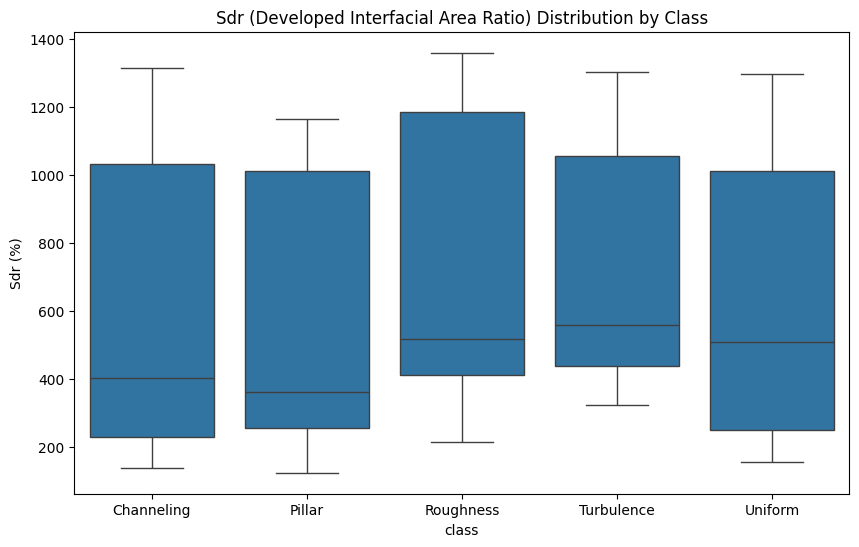

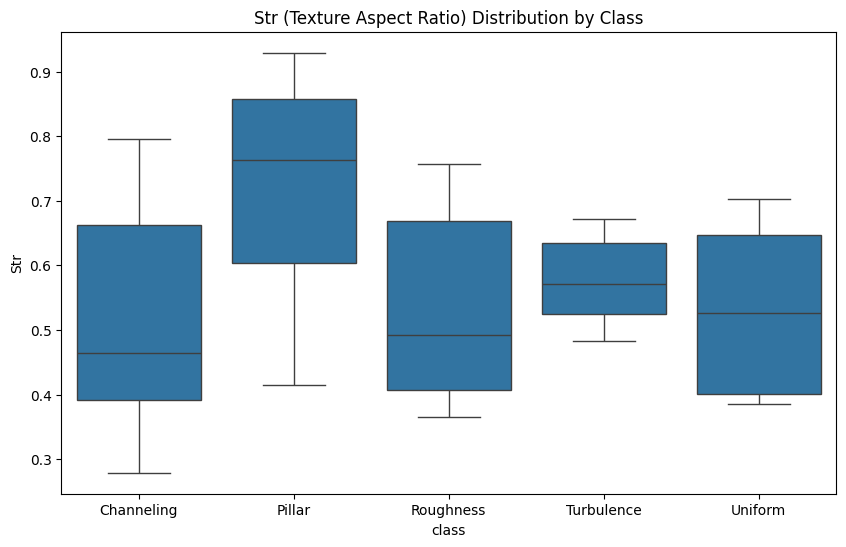

In [ ]:
print("SDR:")
print(df.groupby('class')['sdr'].describe())
print("\nSTR:")
print(df.groupby('class')['str'].describe())
print("\nDrainage Density:")
print(df.groupby('class')['drainage_density'].describe())
print("\nMax Stream Order:")
print(df.groupby('class')['max_stream_order'].describe())
print("\nBifurcation Ratio:")
print(df.groupby('class')['bifurcation_ratio'].describe())
print("\nTortuosity:")
print(df.groupby('class')['tortuosity'].describe())

plt.figure(figsize=(10,6))
sns.boxplot(x='class', y='sdr', data=df)
plt.title('Sdr (Developed Interfacial Area Ratio) Distribution by Class')
plt.ylabel('Sdr (%)')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='class', y='str', data=df)
plt.title('Str (Texture Aspect Ratio) Distribution by Class')
plt.ylabel('Str')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='class', y='drainage_density', data=df)
plt.title('Drainage Density Distribution by Class')
plt.ylabel('Drainage Density')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='class', y='max_stream_order', data=df)
plt.title('Max Stream Order Distribution by Class')
plt.ylabel('Max Stream Order')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='class', y='bifurcation_ratio', data=df)
plt.title('Bifurcation Ratio Distribution by Class')
plt.ylabel('Bifurcation Ratio')
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(x='class', y='tortuosity', data=df)
plt.title('Channel Tortuosity Distribution by Class')
plt.ylabel('Tortuosity')
plt.show()